<div style="text-align: center;">
  <h1><strong>HANDWRITTEN SIGNATURE VERIFICATION </strong></h1>
</div>


Xác thực chữ ký trong bài toán này không chỉ là phân biệt chữ ký thật hay giả, mà còn phải xem nó có giống với mẫu chữ lý đã lưu trong CSDL hay không.
### **Vì sao chọn Triplet Network**
* Không cần huấn luyện lại khi có chữ ký mới, chỉ cần trích xuất đặc trưng rồi lưu vào CSDL.
* Tốt hơn so với các 


### **Tiền xử lý dữ liệu**
* Đọc ảnh chữ ký từ thư mục.
* Chuyển ảnh về grayscale (ảnh đen trắng).
* Resize ảnh về 224 x 224 (để phù hợp với mô hình CNN sau này).
* Chuẩn hóa ảnh về khoảng [0,1] để giúp mô hình học tốt hơn.

In [1]:
# Xác định xem đã truy cập đến thư mục dataset được chưa
import os

# Đường dẫn thư mục chính
dataset_path = "./Dataset/"  # Thay bằng đường dẫn thực tế

# Duyệt qua từng thư mục con (dataset1, dataset2,...)
for dataset in sorted(os.listdir(dataset_path)):
    dataset_folder = os.path.join(dataset_path, dataset)
    if os.path.isdir(dataset_folder):  # Kiểm tra nếu là thư mục
        forge_path = os.path.join(dataset_folder, "forge")
        real_path = os.path.join(dataset_folder, "real")

        # Lấy danh sách ảnh trong từng thư mục
        forge_images = [os.path.join(forge_path, img) for img in os.listdir(forge_path)]
        real_images = [os.path.join(real_path, img) for img in os.listdir(real_path)] if os.path.exists(real_path) else []

        print(f"📂 {dataset} - {len(real_images)} real, {len(forge_images)} forged")

# Chọn một ảnh để thử tiền xử lý
image_path = real_images[0]  # Lấy ảnh thật đầu tiên
print("Sample image path:", image_path)

📂 dataset1 - 60 real, 60 forged
📂 dataset2 - 60 real, 60 forged
📂 dataset3 - 150 real, 150 forged
📂 dataset4 - 90 real, 90 forged
Sample image path: ./Dataset/dataset4\real\00201002.png


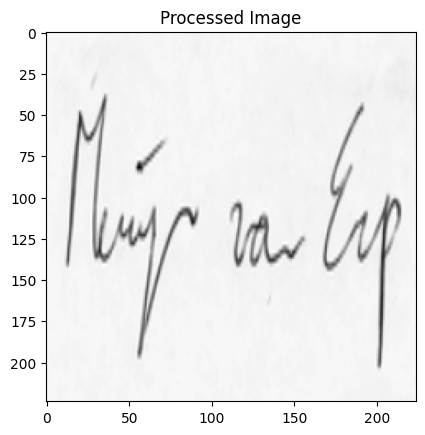

In [2]:
# Tiền xử lý hình ảnh

import cv2
import numpy as np
import tensorflow as tf
import os



# Kích thước ảnh chuẩn cho mô hình
IMG_SIZE = (224, 224)

# Hàm tiền xử lý ảnh
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale
    img = cv2.resize(img, IMG_SIZE)  # Resize ảnh
    img = img / 255.0  # Chuẩn hóa pixel về [0,1]
    img = np.expand_dims(img, axis=-1)  # Thêm kênh màu (128, 128, 1)
    return img

# Ví dụ: Load một ảnh để kiểm tra
sample_path = "./Dataset/dataset1/real/00100001.png"  # Thay đường dẫn thực tế
processed_img = load_and_preprocess_image(sample_path)

# Hiển thị ảnh sau khi tiền xử lý
import matplotlib.pyplot as plt
plt.imshow(processed_img.squeeze(), cmap="gray")
plt.title("Processed Image")
plt.show()


### **Load toàn bộ dữ liệu và tạo tập huấn luyện**

Thực hiện duyệt dataset và chia thành tập huấn luyện: train 80%, test 20%.

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Thư mục chứa dataset
dataset_path = "./Dataset"

# Danh sách lưu dữ liệu và nhãn
images = []
labels = []

# Duyệt qua từng dataset
for dataset in sorted(os.listdir(dataset_path)):
    dataset_folder = os.path.join(dataset_path, dataset)

    if os.path.isdir(dataset_folder):
        forge_path = os.path.join(dataset_folder, "forge")
        real_path = os.path.join(dataset_folder, "real")

        real_count = 0
        forge_count = 0

        # Load chữ ký thật
        if os.path.exists(real_path):
            for img_name in os.listdir(real_path):
                img_path = os.path.join(real_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"⚠ Lỗi đọc ảnh: {img_path}")  # In ra những ảnh không đọc được
                if img is not None:
                    img = cv2.resize(img, (224, 224)) / 255.0
                    images.append(np.expand_dims(img, axis=-1))
                    labels.append(1)  # 1 = chữ ký thật
                    real_count += 1

        # Load chữ ký giả
        if os.path.exists(forge_path):
            for img_name in os.listdir(forge_path):
                img_path = os.path.join(forge_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"⚠ Lỗi đọc ảnh: {img_path}")  # In ra những ảnh không đọc được
                if img is not None:
                    img = cv2.resize(img, (224, 224)) / 255.0
                    images.append(np.expand_dims(img, axis=-1))
                    labels.append(0)  # 0 = chữ ký giả
                    forge_count += 1

        print(f"{dataset}: {real_count} real | {forge_count} forged")

# Chuyển danh sách thành numpy array
images = np.array(images)
labels = np.array(labels)

# In số lượng ảnh và nhãn
print(f"Tổng số ảnh: {len(images)}, Tổng số nhãn: {len(labels)}")

# Chia tập huấn luyện (80%) và tập kiểm tra (20%)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# In kích thước dữ liệu sau khi chia
print(f"\n📂 Dữ liệu huấn luyện: {X_train.shape}, Nhãn: {y_train.shape}")
print(f"📂 Dữ liệu kiểm tra: {X_test.shape}, Nhãn: {y_test.shape}")


dataset1: 60 real | 60 forged
dataset2: 60 real | 60 forged
dataset3: 150 real | 150 forged
dataset4: 90 real | 90 forged
Tổng số ảnh: 720, Tổng số nhãn: 720

📂 Dữ liệu huấn luyện: (576, 224, 224, 1), Nhãn: (576,)
📂 Dữ liệu kiểm tra: (144, 224, 224, 1), Nhãn: (144,)


### **Tạo CNN trích xuất đặc trưng**

#### Mô hình này sẽ nhận ảnh đầu vào (224, 224, 1) và trả về vector đặc trưng.

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_signature_model(input_shape=(224, 224, 1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)  # Embedding vector
    outputs = layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=1))(x)  # Chuẩn hóa vector
    model = Model(inputs=inputs, outputs=outputs)  # Kết nối đầu vào và đầu ra
    return model

signature_model = create_signature_model()
signature_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,560 (1.54 MB)

 Trainable params: 402,560 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

### **Tạo Triplet Loss**

#### Hàm loss đảm bảo Anchor gần Positive hơn Negative.

In [6]:
import tensorflow.keras.backend as K

def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
        pos_dist = K.sum(K.square(anchor - positive), axis=-1)
        neg_dist = K.sum(K.square(anchor - negative), axis=-1)
        return K.mean(K.maximum(pos_dist - neg_dist + margin, 0))
    return loss


### **Xây dựng mô hình Triplet CNN**

### Chúng ta sẽ dùng cùng một CNN để trích xuất đặc trưng cho cả 3 ảnh Anchor, Positive, Negative.

In [8]:
# Định nghĩa 3 đầu vào
anchor_input = layers.Input(shape=(224, 224, 1))
positive_input = layers.Input(shape=(224, 224, 1))
negative_input = layers.Input(shape=(224, 224, 1))

# Dùng cùng một CNN để trích xuất đặc trưng
anchor_embedding = signature_model(anchor_input)
positive_embedding = signature_model(positive_input)
negative_embedding = signature_model(negative_input)

# Gom lại thành 1 tensor
merged_output = layers.Concatenate(axis=-1)([anchor_embedding, positive_embedding, negative_embedding])


# Định nghĩa mô hình
triplet_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_output)
triplet_model.compile(loss=triplet_loss(margin=1.0), optimizer='adam')
triplet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │    402,560 │ input_layer_5[0]… │
│ (Functional)        │                   │            │ input_layer_6[0]… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ functional[3][0], │
│ (Concatenate)       │                   │            │ functional[4][0], │
│                     │                   │            │ functional[5][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 402,560 (1.54 MB)

 Trainable params: 402,560 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

### **Chuẩn bị dữ liệu Triplet**

In [9]:
def create_triplets(images, labels):
    triplets = []
    num_classes = len(np.unique(labels))  # Số lượng người ký
    indices = {i: np.where(labels == i)[0] for i in range(num_classes)}

    for i in range(len(images)):
        anchor = images[i]
        label = labels[i]

        # Chọn 1 ảnh Positive (cùng nhóm)
        positive_idx = np.random.choice(indices[label])
        while positive_idx == i:
            positive_idx = np.random.choice(indices[label])
        positive = images[positive_idx]

        # Chọn 1 ảnh Negative (khác nhóm)
        negative_label = np.random.choice([l for l in range(num_classes) if l != label])
        negative_idx = np.random.choice(indices[negative_label])
        negative = images[negative_idx]

        triplets.append((anchor, positive, negative))

    return np.array(triplets)

# Tạo dữ liệu Triplet
train_triplets = create_triplets(X_train, y_train)
test_triplets = create_triplets(X_test, y_test)


### **Huấn luyện mô hình**

In [11]:
triplet_model.fit([train_triplets[:,0], train_triplets[:,1], train_triplets[:,2]], 
                  np.zeros(len(train_triplets)),  # Triplet Loss không cần nhãn
                  epochs=20, batch_size=16)


Epoch 1/20
24/36 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - loss: 1.0000 

KeyboardInterrupt: 

### **Xác thực chữ ký**

#### Sau khi huấn luyện, ta kiểm tra bằng cách tính khoảng cách giữa Anchor và Test Signature:

In [ ]:
import numpy as np

def verify_signature(model, anchor_img, test_img, threshold=0.5):
    anchor_embedding = model.predict(np.expand_dims(anchor_img, axis=0))
    test_embedding = model.predict(np.expand_dims(test_img, axis=0))
    distance = np.linalg.norm(anchor_embedding - test_embedding)
    return distance < threshold  # Nếu nhỏ hơn ngưỡng, xác nhận là chữ ký hợp lệ

# Kiểm tra trên một chữ ký mới
is_valid = verify_signature(signature_model, X_test[0], X_test[1])
print("✅ Chữ ký hợp lệ" if is_valid else "❌ Chữ ký giả mạo")
